In [1]:
import json
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sys.path.append('..')
from utils.amt_inout import bounded_curve, bounded_sigmoid
from utils.stock_loader import Loader

In [2]:
SYM = 'DIA'  # emerging markets
START = '1965-01-01'
PARAM_PATH = '../data/inout_params_dow.pkl'
loader = Loader([SYM], START)
df = loader.download()
df.set_index('Date', drop=True, inplace=True)
df.columns = [
    'open', 'high', 'low', 'close', 'value', 'logval',
    'intraday_change', 'day_to_day_change', 'overnight_change']
df.logval.fillna(method='ffill')
for adj in ['overnight_change', 'day_to_day_change']:
    df[adj] = pd.Series(
        np.concatenate([df[adj].values[1:], [np.nan]]), index=df.index)
print(df.shape)
df.head(10)

[*********************100%***********************]  1 of 1 completed


Generating derived columns...
(6765, 9)


,open,high,low,close,value,logval,intraday_change,day_to_day_change,overnight_change
Date,,,,,,,,,
1998-01-20 00:00:00+00:00,44.640259,78.812500,78.843750,77.406250,77.81250,3.798636,1.012851,0.987708,0.990880
1998-01-21 00:00:00+00:00,44.091557,77.843750,78.375000,77.281250,78.09375,3.786268,0.996799,0.991570,0.991570
1998-01-22 00:00:00+00:00,43.719845,77.187500,77.859375,76.937500,77.18750,3.777802,1.000000,0.997571,1.004049
1998-01-23 00:00:00+00:00,43.613647,77.000000,77.750000,76.312500,77.50000,3.775370,0.993548,1.004058,1.004870
1998-01-26 00:00:00+00:00,43.790627,77.312500,77.671875,76.937500,77.37500,3.779420,0.999192,1.011722,0.997575
1998-01-27 00:00:00+00:00,44.303940,78.218750,78.562500,77.078125,77.12500,3.791074,1.014182,1.011586,1.001998
1998-01-28 00:00:00+00:00,44.817257,79.125000,79.234375,78.218750,78.37500,3.802593,1.009569,1.003555,0.999210
1998-01-29 00:00:00+00:00,44.976578,79.406250,80.250000,78.890625,79.06250,3.806142,1.004348,0.997834,1.006690
1998-01-30 00:00:00+00:00,44.879177,79.234375,79.937500,78.968750,79.93750,3.803974,0.991204,1.022481,1.017551


In [3]:
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    1
overnight_change     1
dtype: int64

In [4]:
df.fillna(method='ffill', inplace=True)
df.isnull().sum()

open                 0
high                 0
low                  0
close                0
value                0
logval               0
intraday_change      0
day_to_day_change    0
overnight_change     0
dtype: int64

In [5]:
df.high[(df.high != df.low)]

Date
1998-01-20 00:00:00+00:00     78.812500
1998-01-21 00:00:00+00:00     77.843750
1998-01-22 00:00:00+00:00     77.187500
1998-01-23 00:00:00+00:00     77.000000
1998-01-26 00:00:00+00:00     77.312500
                                ...    
2024-11-29 00:00:00+00:00    450.089996
2024-12-02 00:00:00+00:00    448.739990
2024-12-03 00:00:00+00:00    447.890015
2024-12-04 00:00:00+00:00    450.940002
2024-12-05 00:00:00+00:00    448.670013
Name: high, Length: 6642, dtype: float64

In [6]:
SIM_START = pd.to_datetime('2009-01-02', utc=True)  # first day of legit open/close values
SIM_START

Timestamp('2009-01-02 00:00:00+0000', tz='UTC')

In [7]:
len(df.index >= SIM_START)

6765

In [8]:
def get_random_params():
    k = np.random.uniform(1, 10)
    if np.random.choice([True, False]):
        k = 1/k
    return {
        'time_param': np.random.randint(5, 250),
        'method':     np.random.choice(['ew', 'ma', 'linear']), #'linear_ma']),
        't':          np.random.uniform(0, 1),
        'k':          k,
        'as_q':       np.random.choice([True, False]),
        'transform_f': np.random.choice(['bounded_curve', 'bounded_sigmoid'])}

In [9]:
def tweak_best_params(params, factor=2, numeric_only=False):
    '''A small factor should have values very close to current, larger
    values allow wilder fluctuations'''
    time = params['time_param']
    upper = time * factor
    diff = upper - time
    time = np.random.randint(time - diff, upper)
    time = min(max(5, time), 1000)
    
    method = params['method']
    if not numeric_only:
        meths = ['ew', 'ma', 'linear_ma', 'linear']
        idx = meths.index(method)
        ps = np.array([1, 1, 1, 1])
        ps[idx] = factor
        ps = ps / ps.sum()
        method = np.random.choice(meths, p=ps)
    
    t = params['t']
    sd = 1 - 1 / (factor/2 + 1)
    t = min(max(np.random.normal(t, scale=sd), 0.001), 0.999)
    
    k = params['k']
    upper = k * factor
    diff = upper - k
    k = np.random.uniform(k - diff, upper)
    k = min(max(1/10, k), 10)
    
    as_q = params['as_q'] if numeric_only else np.random.choice([True, False]) 
    
    current_transform = params['transform_f']
    other_transform = 'bounded_curve' if current_transform == 'bounded_sigmoid' else 'bounded_sigmoid'
    p_current = 1 / factor
    transform_f = np.random.choice([current_transform, other_transform], p=[p_current, 1 - p_current])
    return {
        'time_param': time,
        'method': method,
        't': t,
        'k': k,
        'as_q': as_q,
        'transform_f': transform_f}

In [10]:
def get_ma(series: pd.Series, time_param: float | int, method: str):
    '''Calculate the moving average
    Args:
    - method: 'ew' | 'ma' | 'linear' | 'linear_ma'
    - time_param:
      - ew=True: (real) the halflife of the exponential weights (no. 
          of  time periods it takes for weight to drop from 1 to 0.5)
      - ew=False: (int) the ma window, or number of days to average 
   over
    '''
    if method == 'ew':
        trend = series.ewm(halflife=time_param, ignore_na=True).mean()
    elif method == 'ma':
        trend = series.rolling(window=int(time_param)).mean()
    elif method.startswith('linear'):
        trend = (series).rolling(window=int(time_param)).apply(lambda x: (x[-1] + x[0]) / 2)
        if method == 'linear_ma':
            trend = trend.rolling(window=int(time_param)).mean()
        trend.fillna(method='bfill', inplace=True)
    return trend

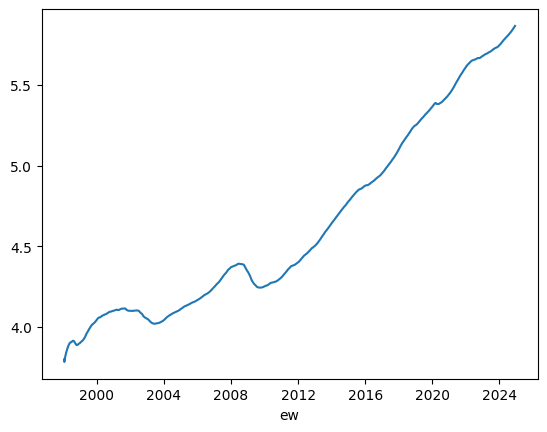

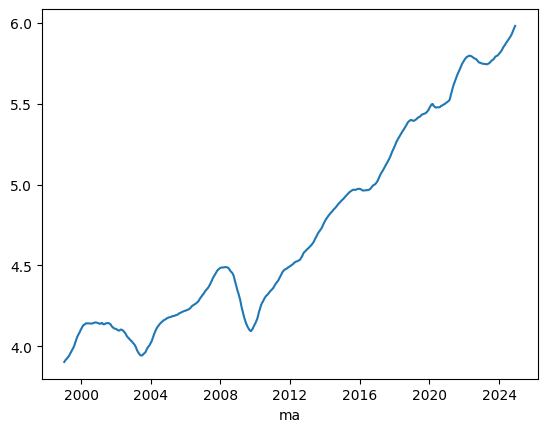

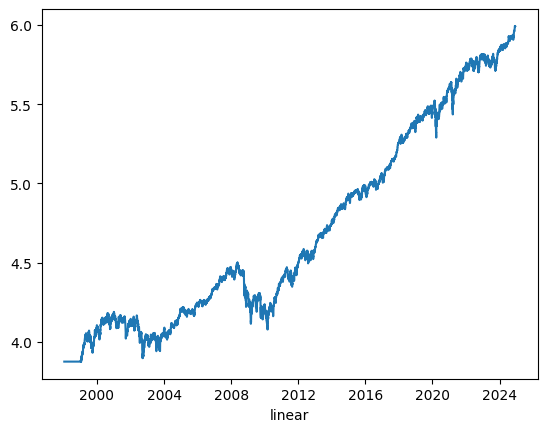

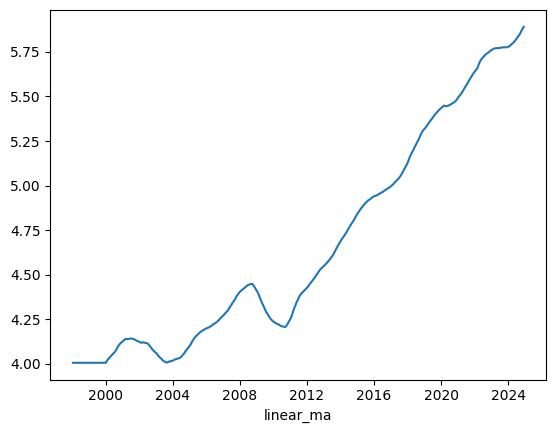

In [11]:
for method in ['ew', 'ma', 'linear', 'linear_ma']:
    plt.plot(get_ma(df.logval, 250, method))
    plt.xlabel(method)
    plt.show()

In [12]:
def get_trend_multiple(series, time_param, method, as_q):
    'Get deviates (as quantiles) relative to trend'
    trend = get_ma(series, time_param, method)
    factor = series / trend
    if as_q:
        factor = factor.rank() / len(factor)
    return factor

In [13]:
def rescale_minmax(series, mn=0, mx=1):
    s = series.copy()
    out_rng = mx - mn
    obs_min = s.min()
    s -= obs_min
    obs_max = s.max()
    s /= obs_max
    s *= out_rng
    s += mn
    return s

In [14]:
def calculate_next_row(row):
    invested = row.invested * row.overnight_change
    total = invested + row.reserve
    target_in = total * row.amt_in
    diff = target_in - invested  # if diff+ buy; - sell
    invested += diff
    reserve = row.reserve - diff
    invested *= row.day_to_day_change
    return invested, reserve, invested + reserve

In [15]:
def simulate(df, params):
    df['trend_factor'] = rescale_minmax(
        get_trend_multiple(
            df.logval,
            params['time_param'],
            method=params['method'],
            as_q=params['as_q']))
    if params['transform_f'] == 'bounded_curve':
        df['amt_in'] = bounded_curve(
            df.trend_factor, params['t'], params['k'], 'down')
    elif params['transform_f'] == 'bounded_sigmoid':
        df['amt_in'] = bounded_sigmoid(
            df.trend_factor, params['t'], params['k'], 'down')
    df = df.loc[df.index >= SIM_START, :].copy()
    df['invested'] = np.nan
    df['reserve'] = np.nan
    df['total'] = np.nan
    df['invested'][0] = df.amt_in[0]
    df['reserve'][0] = 1 - df.amt_in[0]
    df['total'][0] = 1
    for i in range(len(df) - 1) :
        row = df.iloc[i, :]
        try:
            nxt_idx = df.index[i + 1]
            df.loc[nxt_idx, ['invested', 'reserve', 'total']] = (
                calculate_next_row(row))
        except IndexError:
            break
    return df

In [16]:
def run_simulation(
        df, iters=100, current_best=None, best_params=None, 
        param_select='random', factor=2, numeric_only=False):
    orig_df = df.copy()
    do_nothing_res = orig_df.value[-1] / orig_df.loc[SIM_START, 'value']
    print('Do nothing res:', do_nothing_res)
    if current_best is None:
        current_best = 0
    for i in range(iters):
        print('Round', i + 1, end=': ')
        if i == 0 and best_params is not None and param_select == 'random':
            params = best_params  # rerun again on new data
            current_best = 0 
        elif param_select == 'random':
            params = get_random_params()
        else:
            params = (
                tweak_best_params(best_params, factor, numeric_only=numeric_only)
                if best_params is not None else get_random_params())
        df = simulate(orig_df.copy(), params)
        final = df.total[-1]
        print(final)
        if np.isnan(final):
            continue
            #return df, params
        if final > current_best:
            current_best = final
            best_params = params
            print('New best:', current_best)
            print(params)
            plt.plot(df.total, label='best')
            plt.plot(df.value / df.value[0], label='S&P')
            plt.yscale('log')
            plt.legend()
            plt.show()
    return current_best, best_params

In [17]:
try:
    with open(PARAM_PATH, 'rb') as f:
        current_best, best_params = pickle.load(f)
except FileNotFoundError:
    current_best, best_params = None, None
    
current_best, best_params# = None, None

(25.377781435735514,
 {'time_param': 10,
  'method': 'ew',
  't': 0.9306552105501924,
  'k': 6.459530251612707,
  'as_q': True,
  'transform_f': 'bounded_sigmoid'})

Do nothing res: 5.122001439652485
Round 1: 25.22431655284754
New best: 25.22431655284754
{'time_param': 10, 'method': 'ew', 't': 0.9306552105501924, 'k': 6.459530251612707, 'as_q': True, 'transform_f': 'bounded_sigmoid'}


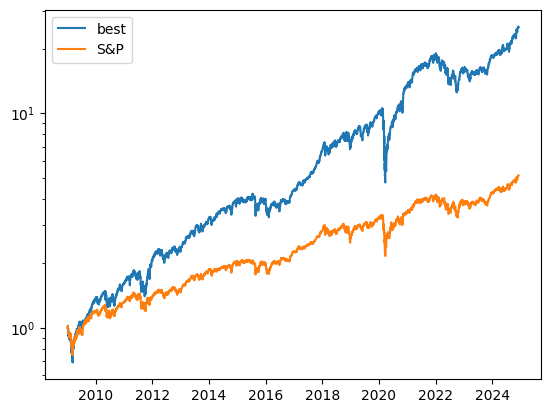

Round 2: 17.40656352483053
Round 3: 1.791739864879348
Round 4: 17.187360149583274
Round 5: 13.429111931790462
Round 6: 11.905858005136938
Round 7: 1.0705513953062276
Round 8: 17.069142665510846
Round 9: 3.90371350890367
Round 10: 1.2750737351199486
Round 11: 1.079518984364651
Round 12: 2.795592566205002
Round 13: 17.205840554704217
Round 14: 20.626851614480426
Round 15: 8.982835141110261
Round 16: 3.1025389531590344
Round 17: 8.742271673362405
Round 18: 2.7314982023180674
Round 19: 3.093630642467733
Round 20: 4.462678287373381
Round 21: 8.193244150299595
Round 22: 6.098990632386463
Round 23: 9.107799317522005
Round 24: 1.3888212362841583
Round 25: 17.44674904426766
Round 26: 8.461931433813664
Round 27: 9.928886991864145
Round 28: 3.3890278211977165
Round 29: 1.6412722599124192
Round 30: 5.73610936256087
Round 31: 6.486034390982017
Round 32: 15.897601058860063
Round 33: 2.964348654019428
Round 34: 14.317031216873493
Round 35: 3.5912057326861024
Round 36: 1.1183599546713159
Round 37: 14.

In [18]:
best_out, params_out = run_simulation(
    df.copy(), current_best=current_best, best_params=best_params)

In [19]:
# initially [1/4, 1/2, 1, 2]
for w in [16, 32, 64, 128]:  # bigger w -> smaller factor -> smaller changes
    factor = 1 + (1/w)
    print('Factor:', factor)
    best_out, params_out = run_simulation(
        df.copy(), 
        iters=10, 
        current_best=best_out, 
        best_params=params_out, 
        param_select='tweak',
        factor=factor,  # closer to 1: small changes; bigger: bigger
        numeric_only=True) 
    print()

Factor: 1.0625
Do nothing res: 5.122001439652485
Round 1: 3.3324227401115074
Round 2: 19.923223276378728
Round 3: 21.961698269947032
Round 4: 6.808717815192513
Round 5: 18.060581251434673
Round 6: 14.938511573027483
Round 7: 3.7552308996208006
Round 8: 18.068395065050225
Round 9: 5.326656188298112
Round 10: 18.063824762042987

Factor: 1.03125
Do nothing res: 5.122001439652485
Round 1: 14.503792853626738
Round 2: 18.061678605400616
Round 3: 18.062694156059067
Round 4: 4.994926564486568
Round 5: 1.9670045849313127
Round 6: 18.064814182882714
Round 7: 12.202878970984392
Round 8: 18.06225622762963
Round 9: 6.454766131625911
Round 10: 4.609634221858126

Factor: 1.015625
Do nothing res: 5.122001439652485
Round 1: 6.548729619344092
Round 2: 18.063445504352185
Round 3: 18.302617642976045
Round 4: 7.303219633736861
Round 5: 24.571311974349094
Round 6: 11.194125535754704
Round 7: 18.064524559823823
Round 8: 5.502771641774169
Round 9: 5.41732466470875
Round 10: 18.064491582962123

Factor: 1.00781

In [20]:
# Force set:
#best_out = 33.55436395490332
#params_out = {'time_param': 153, 'method': 'ew', 't': 0.9977578507998721, 'k': 0.1502092583872895, 'as_q': True, 'transform_f': 'bounded_sigmoid'}

In [21]:
final_out = simulate(df, params_out)

In [22]:
amt_in = final_out['amt_in'][-1]
amt_in

0.9999999998396416

In [23]:
trend_fac = final_out['trend_factor'][-1]
trend_fac

0.6941159077468954

In [24]:
params_out

{'time_param': 10,
 'method': 'ew',
 't': 0.9306552105501924,
 'k': 6.459530251612707,
 'as_q': True,
 'transform_f': 'bounded_sigmoid'}

/Users/damiansp/Learning/marketModeling/notebooks/../utils/amt_inout.py:48: RuntimeWarning: divide by zero encountered in power
  y = 1 / (1 + (x**(np.log(2) / np.log(t)) - 1) ** k)


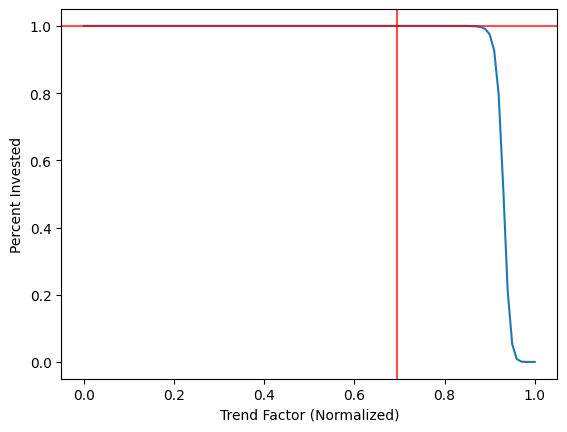

In [25]:
xs = np.linspace(0, 1, 101)
if params_out['transform_f'] == 'bounded_curve':
    ys = bounded_curve(xs, params_out['t'], params_out['k'], 'down')
else:
    ys = bounded_sigmoid(xs, params_out['t'], params_out['k'], 'down')
plt.xlabel('Trend Factor (Normalized)')
plt.ylabel('Percent Invested')
plt.plot(xs, ys)
plt.axhline(amt_in, color='r', alpha=0.7)
plt.axvline(trend_fac, color='r', alpha=0.7);

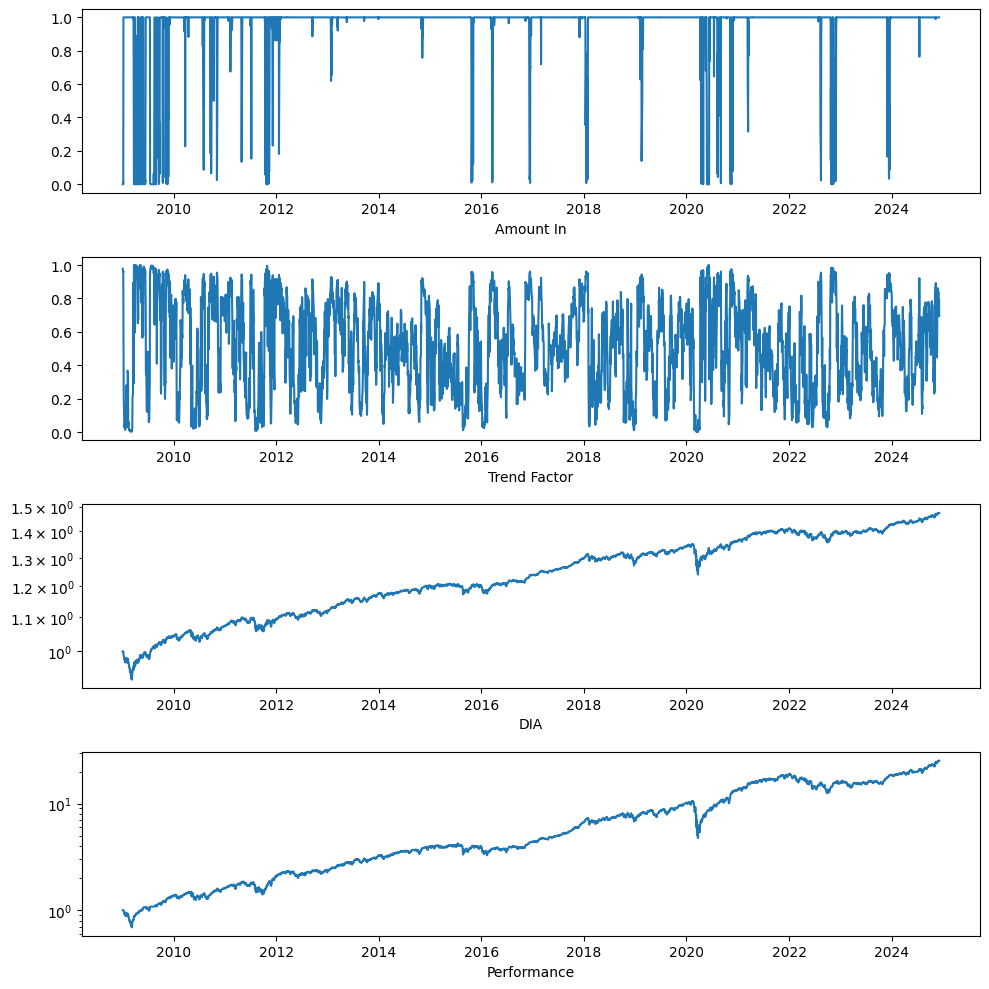

In [26]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in)
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor)
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot(final_out.logval / final_out.logval[0])
plt.xlabel('DIA')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total)
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [27]:
N = 500
#plt.figure(figsize=(10, 10))
#plt.subplot(4, 1, 1)
#plt.plot(final_out.amt_in[:N])
#plt.xlabel('Amount In')

#plt.subplot(4, 1, 2)
#plt.plot(final_out.trend_factor[:N])
#plt.xlabel('Trend Factor')

#plt.subplot(4, 1, 3)
#plt.plot((final_out.logval / final_out.logval[0])[:N])
#plt.xlabel('DIA')
#plt.yscale('log')

#plt.subplot(4, 1, 4)
#plt.plot(final_out.total[:N])
#plt.xlabel('Performance')
#plt.yscale('log')
#plt.tight_layout();

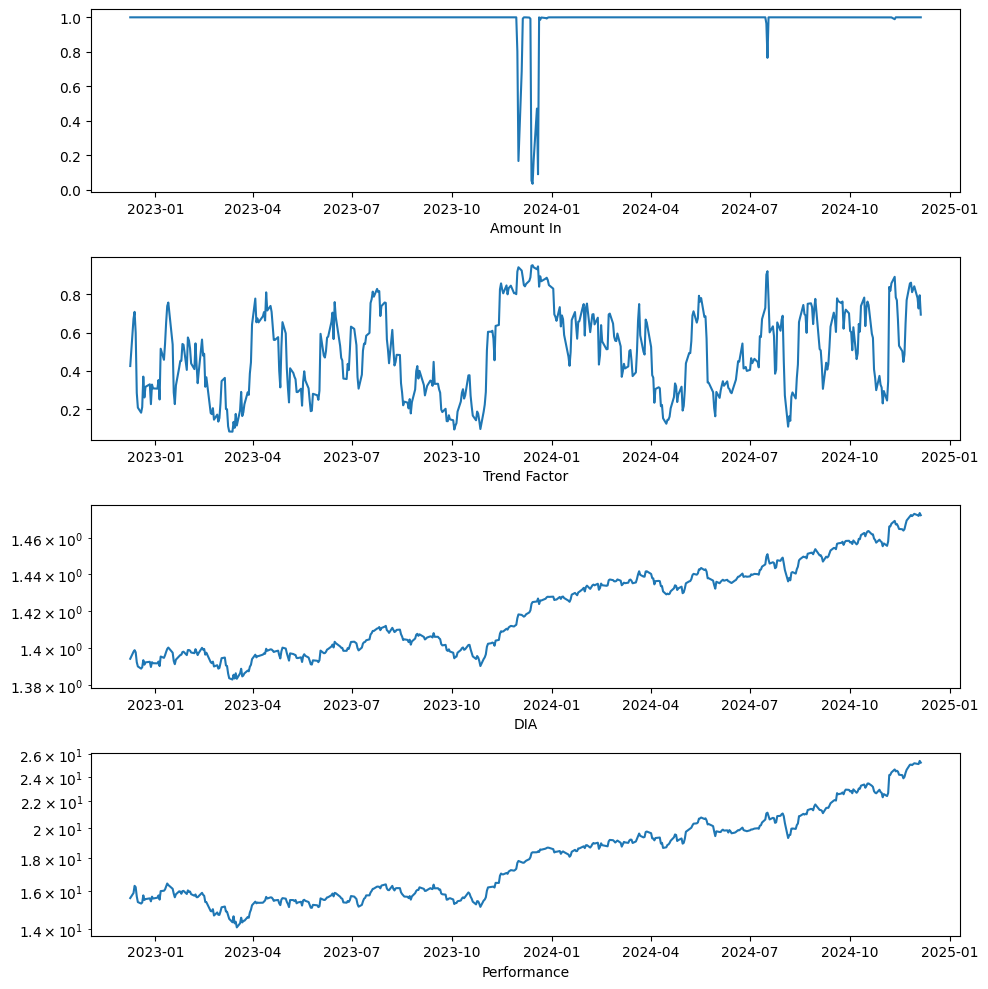

In [28]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(final_out.amt_in[-N:])
plt.xlabel('Amount In')

plt.subplot(4, 1, 2)
plt.plot(final_out.trend_factor[-N:])
plt.xlabel('Trend Factor')

plt.subplot(4, 1, 3)
plt.plot((final_out.logval / final_out.logval[0])[-N:])
plt.xlabel('DIA')
plt.yscale('log')

plt.subplot(4, 1, 4)
plt.plot(final_out.total[-N:])
plt.xlabel('Performance')
plt.yscale('log')
plt.tight_layout();

In [29]:
frac_in = round(final_out['amt_in'][-1], 4)
frac_in

1.0

In [30]:
# n days
n = (df.index >= SIM_START).sum()
# n years
t = n / 250
# amt at start
p = df.loc[SIM_START, 'value']
amt = df.iloc[-1].value
p, t, amt

(87.94999694824219, 16.036, 450.4800109863281)

In [31]:
# annualized rate of return
r = best_out**(1/t) 
r - 1

0.22297343822561655

In [32]:
with open('daily_params.json', 'r') as f_in:
    j = json.load(f_in)
    with open('daily_params.json', 'w') as f_out:
        j['dia'] = [r, frac_in]
        print(j)
        json.dump(j, f_out)

{'sp': [1.1220406554060482, 1.0], 'dia': [1.2229734382256165, 1.0], 'nas': [1.2434524185684623, 1.0], 'rus': [1.2988011092906713, 1.0], 'jpxn': [1.0756554016072677, 0.0], 'ktec': [1.6544411022099241, 0.0], 'eem': [1.2065381219217166, 0.9471], 'nfty': [1.2744188751239343, 1.0], 'gdx': [1.3543935007901438, 0.9969]}


In [33]:
stop

NameError: name 'stop' is not defined

In [34]:
with open(PARAM_PATH, 'wb') as f:
    pickle.dump([best_out, params_out], f)
    
best_out, params_out

(25.22431655284754,
 {'time_param': 10,
  'method': 'ew',
  't': 0.9306552105501924,
  'k': 6.459530251612707,
  'as_q': True,
  'transform_f': 'bounded_sigmoid'})